# Initialization

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from IPython.display import display, clear_output
from tqdm.auto import tqdm
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity
from datagen import pseudoset as pseudoset
import numpy as np
import pickle
import os
import sys
from datagen.genset import GenSet
import time

ROOT = os.path.join("./")
sys.path.append(ROOT + "lib")
sys.path.append(ROOT + "models")
sys.path.append(ROOT + "datagen")

from helpers import *
from sourceset import SourceSet
from fourier import *
from cnn import CNN
from transformer import *
from final import *
from general_trainer import compete, gen_train, itertrain, itercompete
torch.multiprocessing.set_start_method('spawn')

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)
device

'cuda'

In [3]:
# with open(ROOT + "processed_datasets/pseudotrain.pt", "rb") as f:
#   data_train = torch.load(f, map_location=device)
# with open(ROOT + "processed_datasets/pseudovalid.pt", "rb") as f:
#   data_valid = torch.load(f, map_location=device)

# # train = DataLoader(data_train, batch_size=None, shuffle=True, generator=torch.Generator(device=device))
# valid = DataLoader(data_valid, batch_size=None, shuffle=False, generator=torch.Generator(device=device))

# # with open(ROOT + "processed_datasets/data_train.pt", "rb") as f:
# #   data_train = torch.load(f, map_location=device)
with open(ROOT + "processed_datasets/agglomerated_data_valid.pt", "rb") as f:
  data_valid = torch.load(f, map_location=device)

# train = DataLoader(data_train, batch_size=40, shuffle=True, generator=torch.Generator(device=device), collate_fn=padded_collate)
valid = DataLoader(data_valid, batch_size=len(data_valid), shuffle=False, generator=torch.Generator(device=device), collate_fn=tracking_validation_collate)

data_train = GenSet(1400, 200, 0, aggfreq=True, prop=[0.4,0.2,0.2,0.2])
# data_valid = GenSet(256, 256, 0, True)
traini = DataLoader(data_train, batch_size=None, num_workers=6)
# validi = DataLoader(data_valid, batch_size=None)

In [4]:
kwargs = dict(samples=700, out=3, learnsamples=True)
model = WCNFourierModel(**kwargs).to(device)
model_pars = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_pars])

for p in model.named_parameters():
    print(p[0], np.prod(p[1].size()))
print(params)

TypeError: WCNFourierModel.__init__() missing 1 required positional argument: 'wavelet'

# Training Loop (Single)

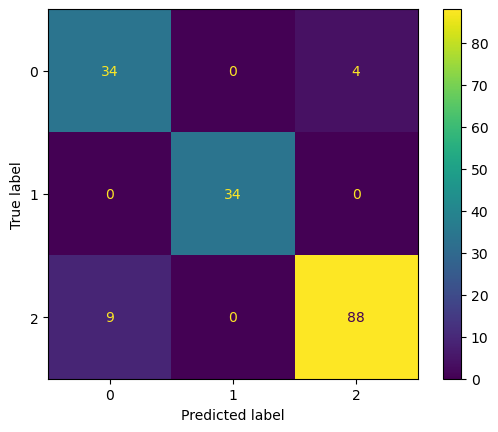

top 5 faileds of valid:  [('V0743 Pup', [21, tensor([21.,  0.,  0.], device='cuda:0')]), ('AL Vol', [21, tensor([21.,  0.,  0.], device='cuda:0')]), ('QW Aqr', [21, tensor([21.,  0.,  0.], device='cuda:0')]), ('V459 Cas', [21, tensor([21.,  0.,  0.], device='cuda:0')]), ('NPM1p68_0422', [20, tensor([ 0.,  0., 20.], device='cuda:0')])]


KeyboardInterrupt: 

In [7]:
# clear the cache
torch.random.manual_seed(0)
torch.cuda.empty_cache()
kwargs = dict(wavelet="haar", samples=700, out=3, learnsamples=True)
model = WCNFourierModel(**kwargs).to(device)
# kwargs = dict(out=4)
# model = CNN(**kwargs).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.000085, weight_decay=10**-5.15, amsgrad=True)
# lr_sched = torch.optim.lr_scheduler.StepLR(optim, step_size=12, gamma=0.4)
# optim = torch.optim.SGD(model.parameters(), lr=0.00005, weight_decay=10**-5.5, momentum=0.9)
loss = torch.nn.CrossEntropyLoss().to(device)
itertrain(model, kwargs, optim, loss, traini, valid, 200, 100, tracking=True)

In [ ]:
# copy model
model2 = WCNFourierModel(**kwargs).to(device)
model2.load_state_dict(model.state_dict())

In [ ]:
optim = torch.optim.SGD(model2.parameters(), lr=0.0000515, weight_decay=10**-7, momentum=0.9)
itertrain(model2, kwargs, optim, loss, traini, valid, 250, 30, tracking=True)

# Model

In [ ]:
# Valid dataloader as list is comprised of ( (N x T x F), N x Label )
datas = [pair[0] for pair in valid]
labels = [pair[1] for pair in valid]
validaccessor = (torch.concat(datas, dim = 0), torch.concat(labels, dim = 0)) # Now just (# of exs) x T x F

selector = 8
pair = (validaccessor[0][selector], validaccessor[1][selector])

plot_from_tensor(pair[0])


or

In [19]:
trainers = []
torch.random.manual_seed(0)
for wv in ["db8", "sym4", "rbio5.5", "bior1.3", "coif1", "coif3", "bior2.2"]:
    model = WCNFourierModel(samples=512, out=3, learnsamples=True, wavelet=wv).to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=0.00008, weight_decay=10**-5, amsgrad=True)
    trainers.append((wv, model, optim))

itercompete(trainers, 20, 250, traini, valid)

<generator object itercompete.<locals>.<genexpr> at 0x7f04ad53a5e0>


terminate called without an active exception
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f03cc8656c0>
Traceback (most recent call last):
  File "/local/home/mpaz/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/local/home/mpaz/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/local/home/mpaz/anaconda3/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/local/home/mpaz/anaconda3/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/local/home/mpaz/anaconda3/lib/python3.11/multiprocessing/connection.py", line 930, in wait
    ready = selector.select(timeout)
           

# Analyze

In [ ]:
torch.cuda.empty_cache()
# model = AnomalyDetector(emb_dim=16, out=4).to(device)
kwargs = dict(samples=1024,out=4)
model = WCNFourierModel(**kwargs).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

traini = GenSet(1024, 1024, aggfreq=True)
ex = next(iter(traini))[0]
model.eval()

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("fiojsda"):
      out = model(ex)

ex2 = next(iter(traini))[0]
t1 = time.perf_counter()
out = model(ex2)
t2 = time.perf_counter()
print("Total Time Elapsed - {}ms".format(t2-t1) * 1000)
      
# for n, p in model.named_parameters():
#   print(n)
#   print(p.grad.norm().item())

# plot_grad_flow(model.cpu().named_parameters())

# print("TOTAL TIME: ", (t2-t1) * 10**3, "ms")
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=8))